In [52]:
from os import listdir

import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Les points d'intérêt

#### Plan

 1. Recherche des points d'intérêt dans des images
 1. Correspondance des points d'intérêt entre 2 images
 1. Classifieur avec Sift

## Recherche des points d'intrêts

Lors de l'affichage des keypoints, la taille du cercle représente la taille du keypoints. Le trait dedans représente la direction.

<IPython.core.display.Javascript object>


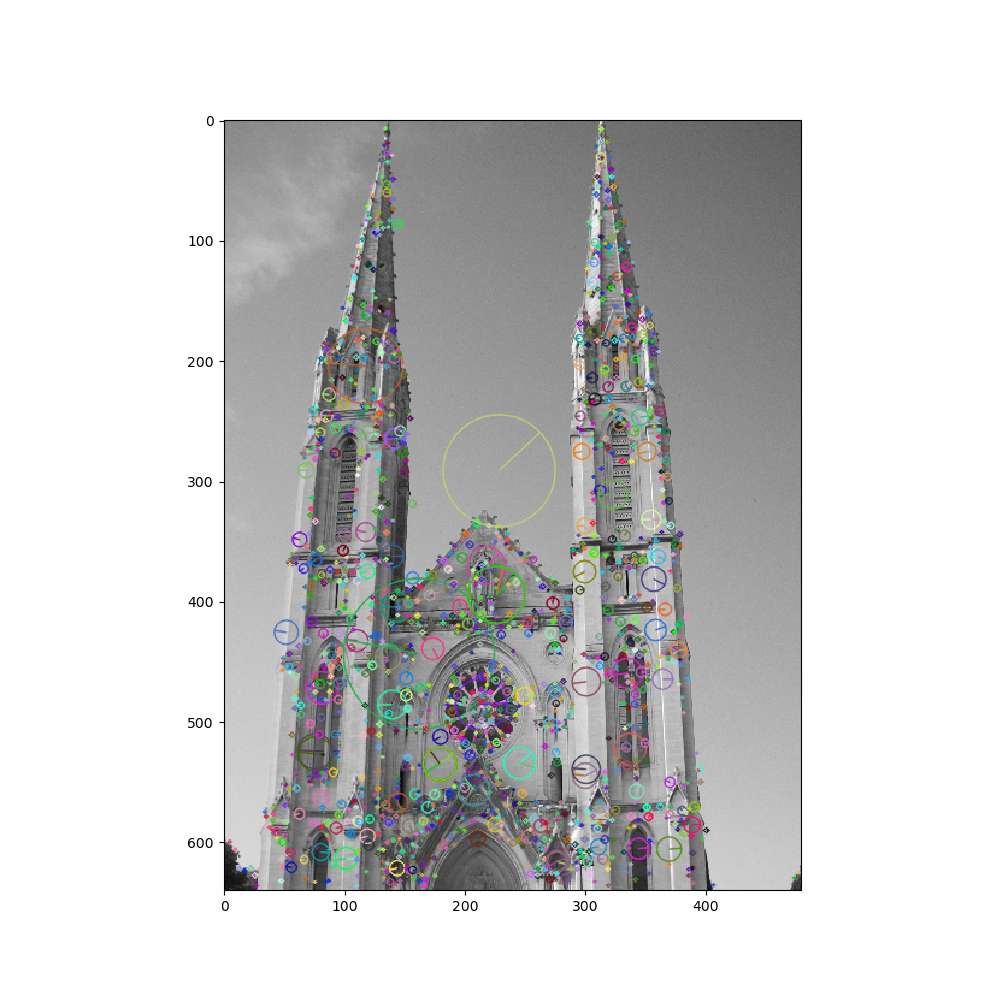

<IPython.core.display.Javascript object>


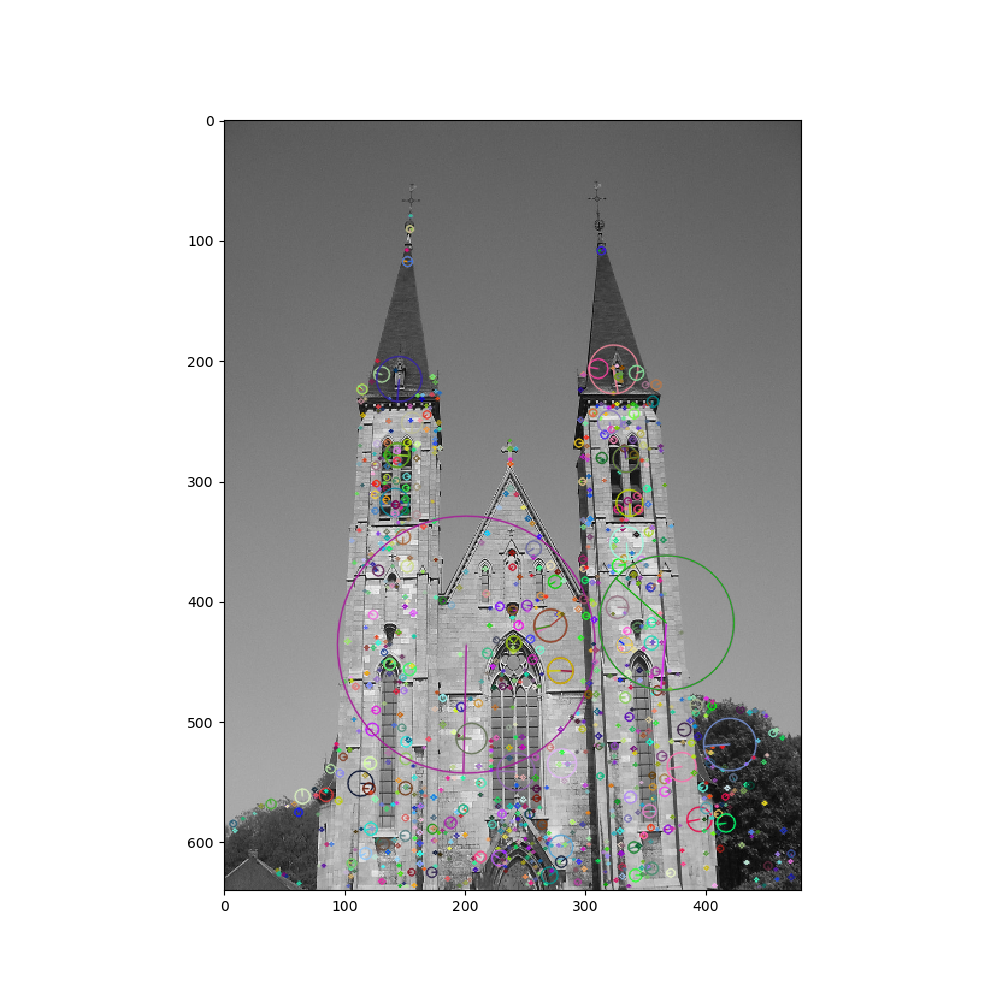

In [53]:
img1 = cv2.imread('../data/images/church01.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../data/images/church02.jpg', cv2.IMREAD_GRAYSCALE)
img1 = cv2.resize(img1, (480, 640))
img2 = cv2.resize(img2, (480, 640))

# === Brute-Force Matching with SIFT Descriptors + ratio ===
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Find descriptors and keypoints
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

kpimg = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kpimg2 = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,10))
plt.imshow(kpimg)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(kpimg2)
plt.show()

## Correspondance des points d'intérêts

La classe BFMatcher d'opencv permet de chercher les keypoints les plus proches entre 2 listes. Cependant les kps les plus proches peuvent ne pas du tout correpondre à des kps semblables. Pour cela, nous utilisons le ratio décrit par David Lowe. Si la distance du kp le plus proche est au moins 25% plus petite que la seconde distance alors le 1er kp est considéré comme proche.

<IPython.core.display.Javascript object>


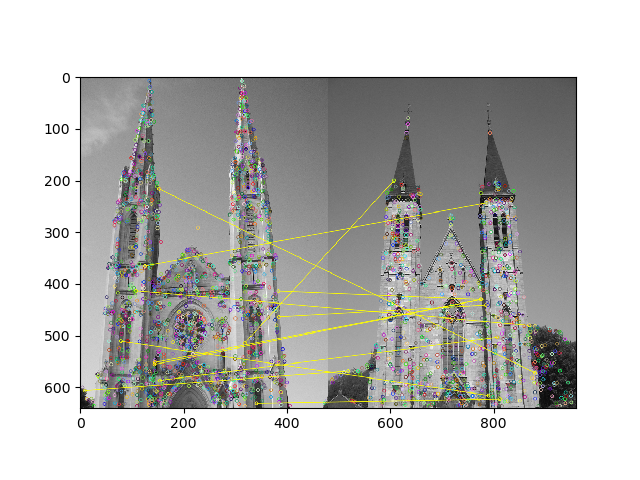

In [62]:
bf = cv2.BFMatcher()
best = []

draw_params = dict(matchColor=(0,255,0), flags=2)
matches = bf.knnMatch(des1,des2, k=2)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

for m, n in matches:
    if m.distance < .75*n.distance:
        best.append([m])
        
best_to_keep = 25

img4 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, best, None, [255,255,0])
plt.figure()
plt.imshow(img4)
plt.show()

## Classifieur

Nous avons 120 images de référence et 6 images _probes_.
Il faut retrouver la classe de l'image _probe_ parmis les classes des images de référence. Pour cela, nous cherchons l'image la plus proche de l'image _probe_ et regardons sa classe.

Pour chaque image de référence, nous stockons les kps pour ne pas les recalculer pour chaque probes.

2 méthodes ont été testées pour chercher l'image la plus proche.

In [64]:
DATASET_PATH = "../data/datasets/image_recognition/data2/"
ref_folder = DATASET_PATH + "References/"
test_folder = DATASET_PATH + "Test/"

test_images = [cv2.imread(test_folder+ f) for f in listdir(test_folder) if ".png" in f]
ref_images = [cv2.imread(ref_folder+ f) for f in listdir(ref_folder) if ".png" in f]

test_labels = [f.split("_")[0] for f in listdir(test_folder) if ".png" in f]
ref_labels = [f.split("_")[0] for f in listdir(ref_folder) if ".png" in f]

print(len(ref_images))
print(len(test_images))
print(len(set(ref_labels)))

120
120
6


In [56]:
sift = cv2.xfeatures2d.SIFT_create()
reference = []

for img in ref_images:
    reference.append(sift.detectAndCompute(img,None))

#### Méthode 1

Pour chercher l'image la plus proche, nous cherchons le kp le plus proche entre les 2 images.

Nous obtenons de bonnes performances quand bien même cette méthode est sensible à des valeurs abérantes : des keypoints très sembables mais qui nont rien avoir entre eux. Par exemple en ne vérifiant pas le ratio vu avant.

Une des hypopthèses pour expliquer ces résultats est que le fond des images est noir. Cela limite la détection de keypoints parasites.

<IPython.core.display.Javascript object>


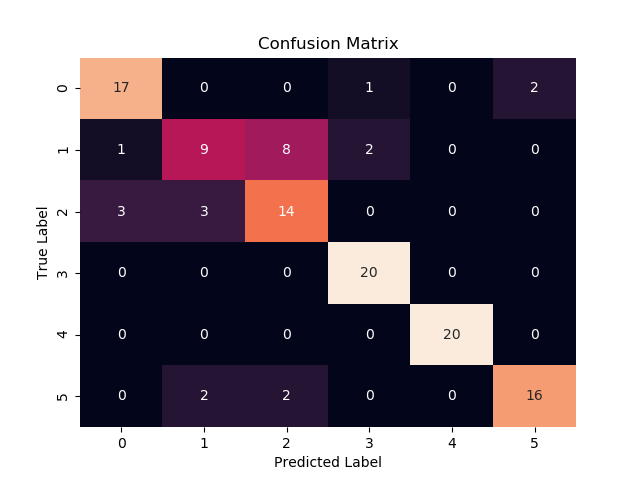

0.8


In [65]:
bf = cv2.BFMatcher()

y_true = []
y_pred = []

for img, label in zip(test_images, test_labels):
    kp, des = sift.detectAndCompute(img,None)
    
    result = []
    for i, (kp, des_r) in enumerate(reference):
        matches = bf.knnMatch(des,des_r, k=1)
        min_dist = min(matches, key=lambda item: item[0].distance)[0].distance
        result.append((min_dist, i))
    
    idx = min(result, key=lambda item: item[0])[1]
    y_true.append(label)
    y_pred.append(ref_labels[idx])
    
confusion = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(confusion, annot=True, cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

print(accuracy_score(y_true, y_pred))

#### Méthode 2

Pour chercher l'image la plus proche, ce coup-ci, nous faisons la moyenne des distances de tous les keypoints valides (par le ratio de David Lowe) puis faisons la moyenne.

Les performances sont moins bonnes. 

In [58]:
bf = cv2.BFMatcher()

y_true = []
y_pred = []

for img, label in zip(test_images, test_labels):
    kp, des = sift.detectAndCompute(img,None)
    
    result = []
    for i, (kp, des_r) in enumerate(reference):
        matches = bf.knnMatch(des,des_r, k=2)
        dist = []
        for m, n in matches:
            if m.distance > .15*n.distance:
                dist.append(m.distance)
        result.append((np.mean(dist), i))
    
    idx = min(result, key=lambda item: item[0])[1]
    y_true.append(label)
    y_pred.append(ref_labels[idx])
    
confusion = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion, annot=True, cbar=False, )
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

print(accuracy_score(y_true, y_pred))

0.7416666666666667
